# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from itertools import product
from tqdm import tqdm

In [2]:
price = pd.read_csv('./data/Netflix_Historical_StockPrice2.csv')
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,98.339996,101.440002,97.820000,101.209999,101.209999,12432200
1,2016-03-29,101.080002,104.330002,101.000000,104.129997,104.129997,16008900
2,2016-03-30,104.650002,104.910004,101.480003,102.190002,102.190002,14705000
3,2016-03-31,102.430000,103.529999,101.050003,102.230003,102.230003,9747500
4,2016-04-01,102.930000,105.790001,102.470001,105.699997,105.699997,14182400


In [3]:
price.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
price['Date'] = pd.to_datetime(price['Date'], format='%Y-%m-%d')

price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 non-null   float64       
 6   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [5]:
price.shape

(1260, 7)

In [6]:
price.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,292.419810,296.933730,287.681095,292.472302,292.472302,8.451711e+06
std,135.356764,137.677319,132.811799,135.274699,135.274699,5.513675e+06
min,85.430000,86.500000,84.500000,85.330002,85.330002,1.144000e+06
25%,160.012501,161.159996,157.865002,159.867504,159.867504,5.018600e+06
50%,308.220001,313.744995,302.919998,309.014999,309.014999,6.938700e+06
75%,371.059998,376.107498,364.540001,370.585007,370.585007,1.006235e+07
max,582.450012,593.289978,570.400024,586.340027,586.340027,5.841040e+07


In [7]:
price.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

price.head()

,Date,High
0,2016-03-28,101.440002
1,2016-03-29,104.330002
2,2016-03-30,104.910004
3,2016-03-31,103.529999
4,2016-04-01,105.790001


In [8]:
price['Year'] = price['Date'].map(lambda ts: ts.year)
price['Week'] =  price['Date'].map(lambda ts: ts.week)
price.head()

,Date,High,Year,Week
0,2016-03-28,101.440002,2016,13
1,2016-03-29,104.330002,2016,13
2,2016-03-30,104.910004,2016,13
3,2016-03-31,103.529999,2016,13
4,2016-04-01,105.790001,2016,13


In [9]:
last_week = -1

price['Week'] = price['Date'].map(lambda ts: ts.week)
price = price.groupby(['Year', 'Week']).agg({'High': 'mean'})

price.shape

(261, 1)

In [10]:
price.head()

High
Year Week            
2016 13    104.000002
     14    105.976001
     15    109.394000
     16    100.624001
     17     93.006000

<AxesSubplot:title={'center':'Original'}, xlabel='Year,Week', ylabel='High'>

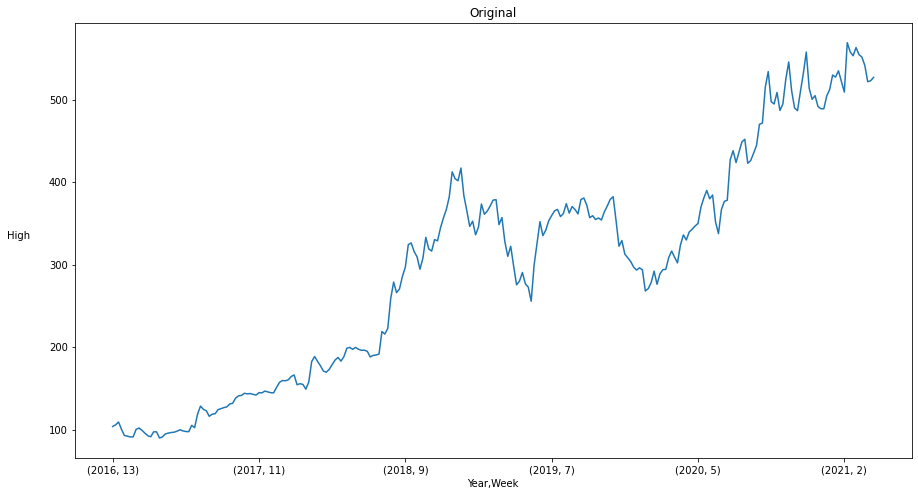

In [11]:
plt.figure(figsize=(15, 8))
plt.title('Original')
plt.ylabel('High', rotation=0, labelpad=30)
price['High'].plot()

Явно выраженный тренд

<Figure size 1080x1440 with 0 Axes>

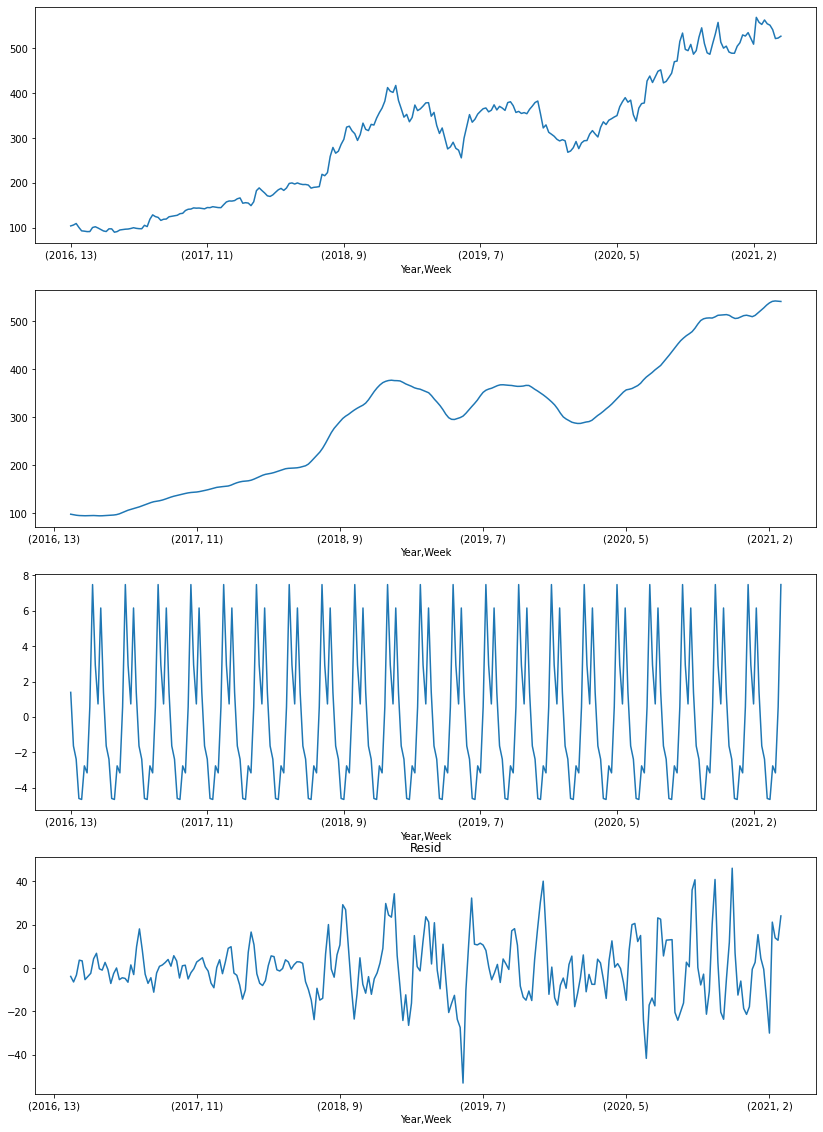

In [12]:
def draw(for_draw):
    plt.figure(figsize=(15, 20))
    decomposition = seasonal_decompose(for_draw, period=12)
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))

    plt.title('Observed')
    decomposition.observed.plot(ax=ax[0])

    plt.title('Trend')
    decomposition.trend.plot(ax=ax[1])

    plt.title('Seasonal')
    decomposition.seasonal.plot(ax=ax[2])

    plt.title('Resid')
    decomposition.resid.plot(ax=ax[3])
    plt.show()

draw(price['High'])

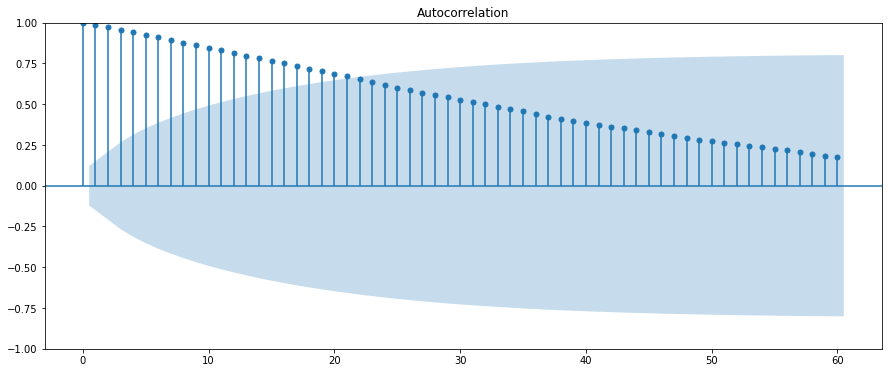

In [13]:
_, ax = plt.subplots(figsize=(15, 6))
plot_acf(price['High'], lags=60, ax=ax);

In [14]:
def check(for_check):
    p_value = adfuller(for_check)[1]

    print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')
    val = ''
    if round(p_value, 4) > 0.05:
        val = 'не '
    print(f'{round(p_value, 4)} > 0.05: Нулевая гипотеза {val}отвергается в пользу альтернативной!')

check(price['High'])

Полученный уровень значимости (p-value): 0.8547.
0.8547 > 0.05: Нулевая гипотеза не отвергается в пользу альтернативной!


In [15]:
price['HighDiff'] = price['High'].diff()
price['HighLog'] = np.log(price['High'])
price['HighLogDiff'] = price['HighLog'].diff()
price.drop(price.head(1).index, inplace=True)
price.head()

High  HighDiff   HighLog  HighLogDiff
Year Week                                             
2016 14    105.976001  1.975999  4.663213     0.018822
     15    109.394000  3.417999  4.694956     0.031743
     16    100.624001 -8.770000  4.611391    -0.083565
     17     93.006000 -7.618001  4.532664    -0.078727
     18     92.318001 -0.687999  4.525239    -0.007425

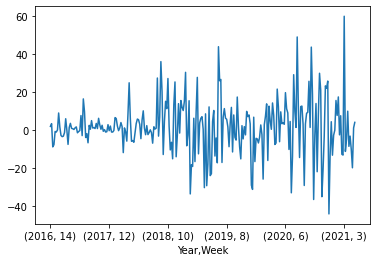

In [16]:
price['HighDiff'].plot()
plt.show()

<Figure size 1080x1440 with 0 Axes>

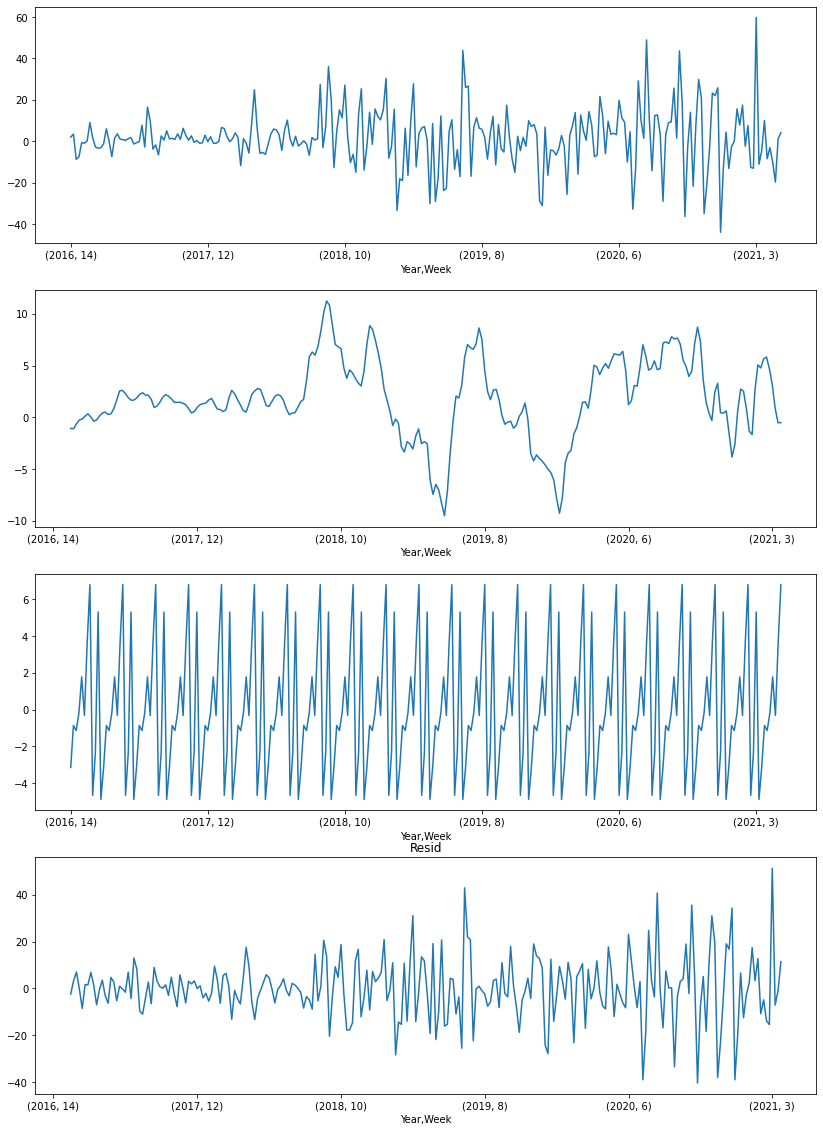

In [17]:
draw(price['HighDiff'])


In [18]:
check(price['HighDiff'])


Полученный уровень значимости (p-value): 0.0.
0.0 > 0.05: Нулевая гипотеза отвергается в пользу альтернативной!


<Figure size 1080x1440 with 0 Axes>

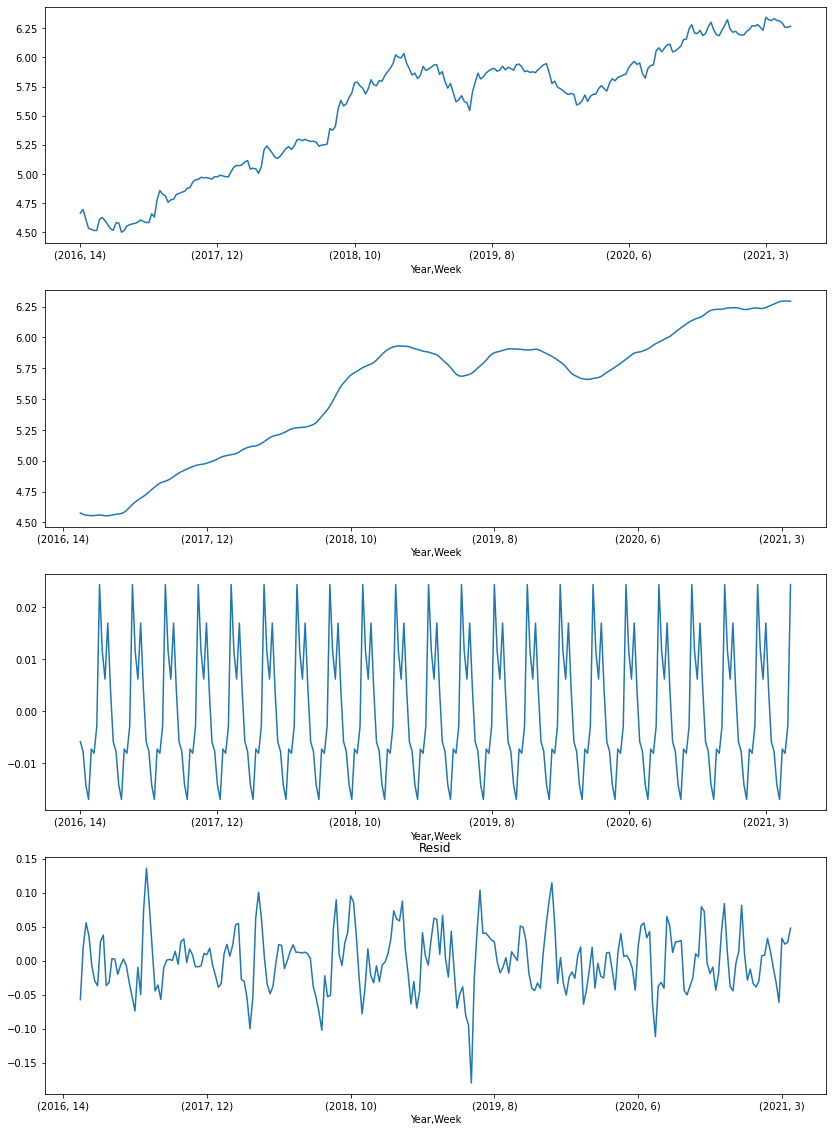

In [19]:
draw(price['HighLog'])

In [20]:
check(price['HighLog'])

Полученный уровень значимости (p-value): 0.6465.
0.6465 > 0.05: Нулевая гипотеза не отвергается в пользу альтернативной!


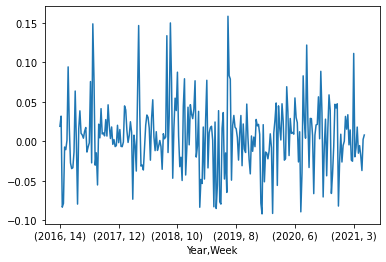

In [21]:
price['HighLogDiff'].plot()
plt.show()

<Figure size 1080x1440 with 0 Axes>

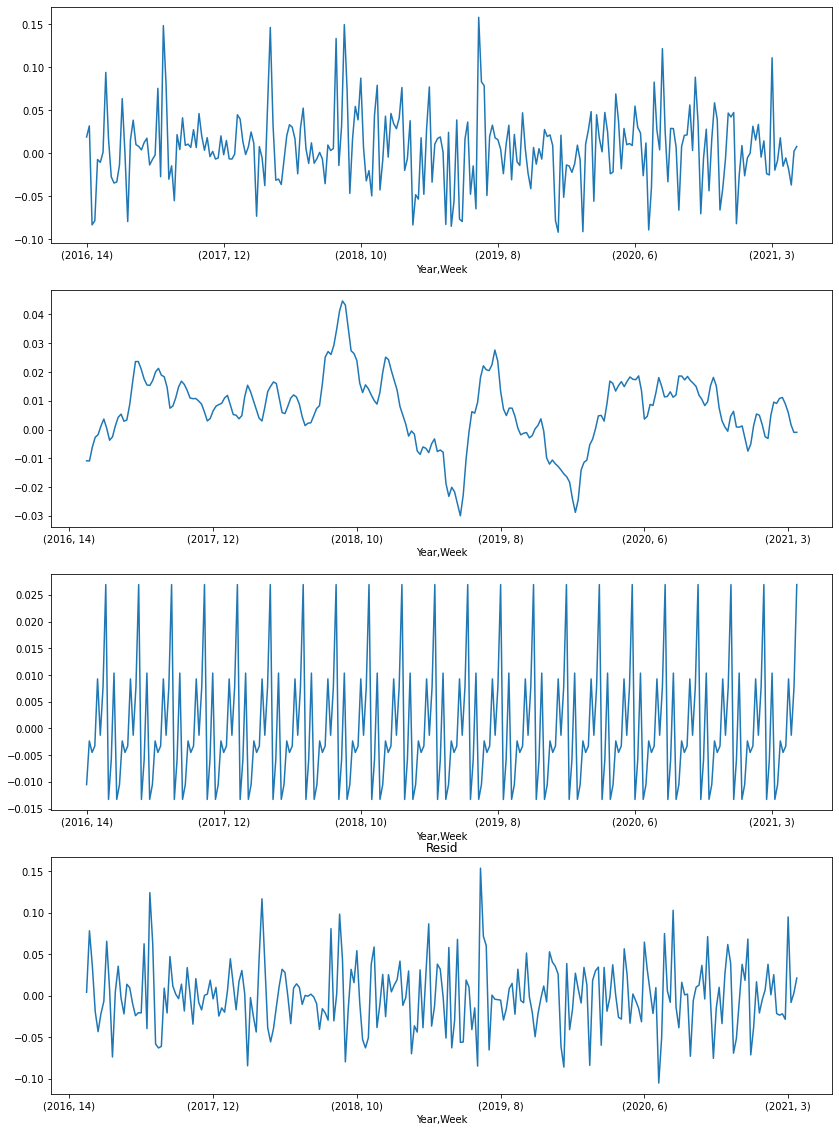

In [22]:
draw(price['HighLogDiff'])

In [23]:
check(price['HighLogDiff'])

Полученный уровень значимости (p-value): 0.0.
0.0 > 0.05: Нулевая гипотеза отвергается в пользу альтернативной!


C:\Python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


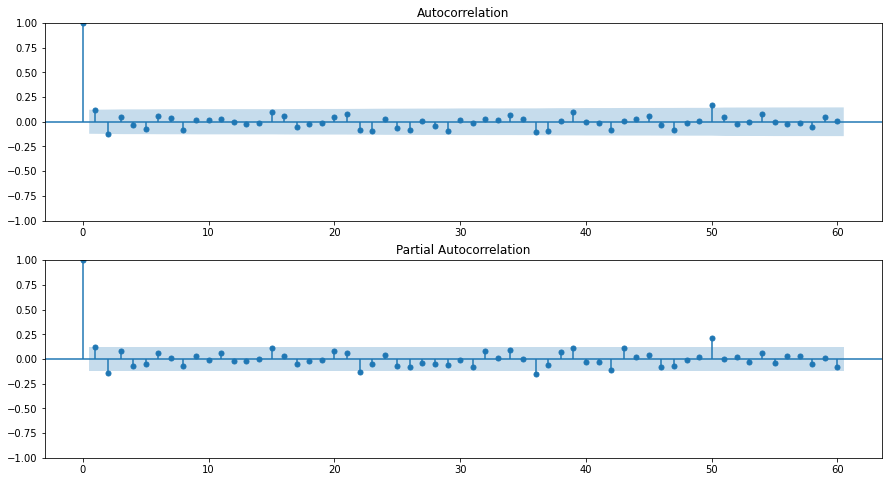

In [24]:

plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(price['HighLogDiff'], lags=60, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(price['HighLogDiff'], lags=60, ax=ax);


(array([ 2.30466319,  2.45830741,  5.22390324, 10.7550949 , 11.06238332,
         4.7629706 ,  1.84373055,  0.46093264,  0.30728843,  0.76822106]),
 array([-0.09210576, -0.0670729 , -0.04204004, -0.01700718,  0.00802568,
         0.03305853,  0.05809139,  0.08312425,  0.10815711,  0.13318997,
         0.15822283]),
 <BarContainer object of 10 artists>)

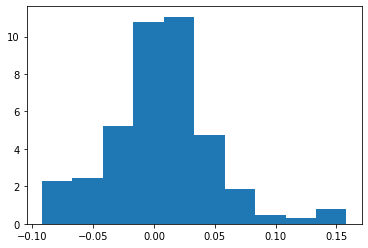

In [25]:
plt.hist(price['HighLogDiff'], density=True, bins=10)

#Напоминает нормальное распределение

In [26]:
d=1
D=1

ps = range(0, 3)
Ps = range(0, 3)
qs = range(0, 3)
Qs = range(0, 3)


cut = int(0.8 * price['HighLog'].size)

high_log_train = price['HighLog'][:cut]
high_train = price['High'][:cut]
high_test = price['High'][cut:]
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
parameters_list.sort()
print(len(parameters_list) )
print(high_train.size)
print(high_test.size)

81
208
52


In [27]:
%%time
import warnings
warnings.filterwarnings('ignore')
results = []

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            high_log_train,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    results.append([model, param, model.aic])

100%|██████████| 81/81 [02:59<00:00,  2.22s/it]

Wall time: 2min 59s


In [28]:
result_table = pd.DataFrame(results)
result_table.columns = ['model', 'param', 'aic']
result_table = result_table.sort_values(by = 'aic', ascending=True)
best_model = result_table.model[0]
best_aic = result_table.aic[0]
best_param = result_table.param[0]
print(result_table.head())

                                                model         param  \
10  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  (0, 1, 0, 1)   
19  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  (0, 2, 0, 1)   
55  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  (2, 0, 0, 1)   
37  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  (1, 1, 0, 1)   
14  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...  (0, 1, 1, 2)   

           aic  
10 -629.658649  
19 -629.413666  
55 -629.169828  
37 -628.974378  
14 -628.491124  


In [29]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            HighLog   No. Observations:                  208
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 263.582
Date:                            Wed, 24 Nov 2021   AIC                           -525.164
Time:                                    17:11:24   BIC                           -521.891
Sample:                                         0   HQIC                          -523.839
                                            - 208                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0039      0.000     12.411      0.000       0.003       0.005
Ljung-Box (L1) (Q):                

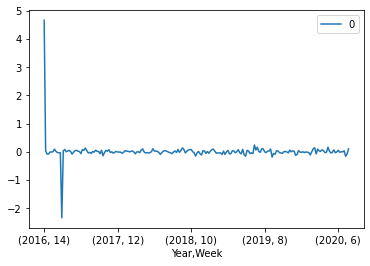

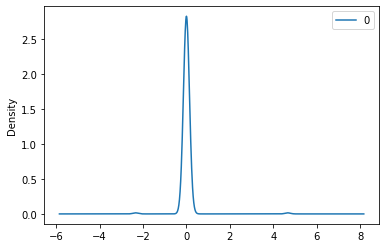

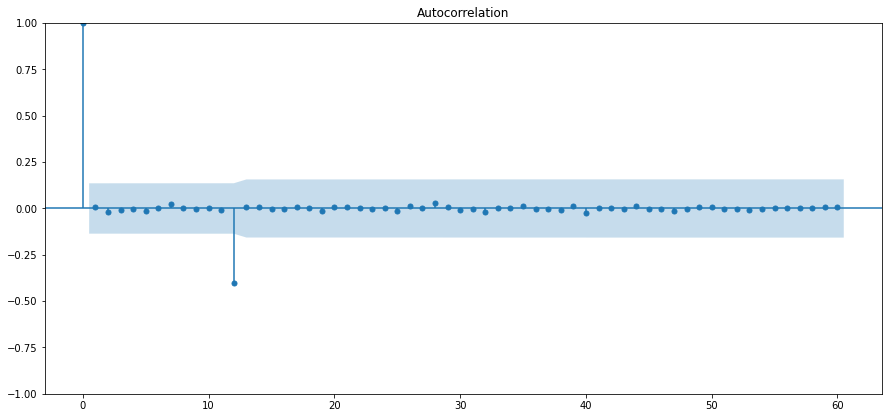

In [30]:
residuals = pd.DataFrame(best_model.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
plt.figure(figsize=(15,15))

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(residuals.values.squeeze(), lags=60, ax=ax);

<AxesSubplot:xlabel='Year,Week'>

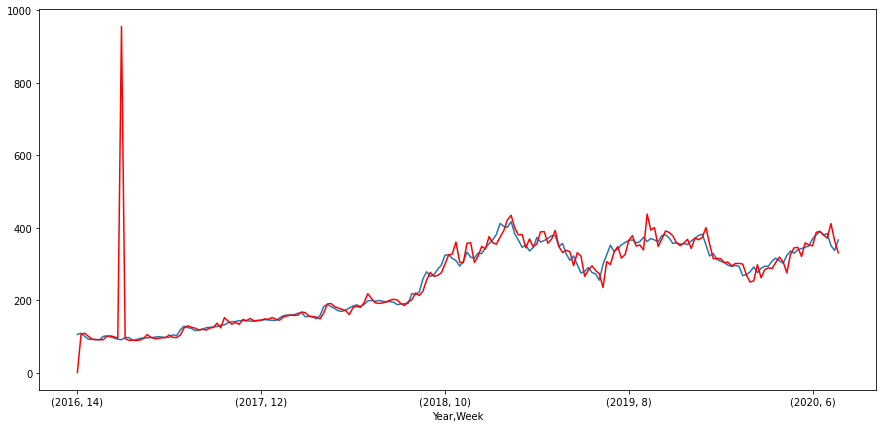

In [31]:
high_model = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

high_train.plot()
high_model.plot(c='r')

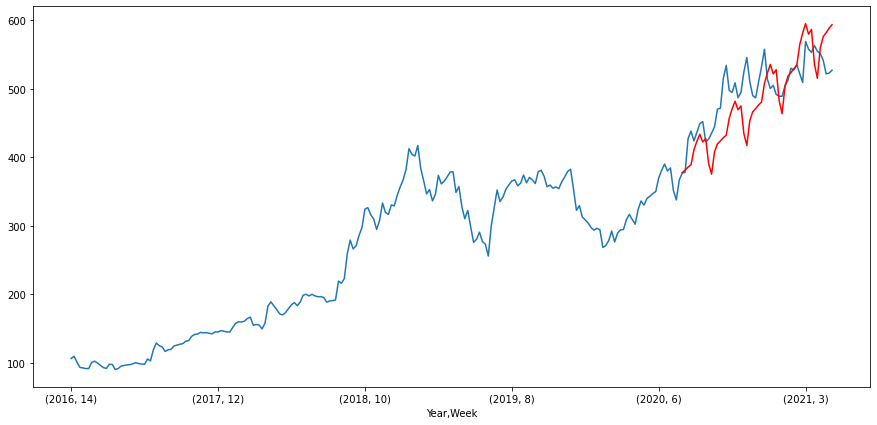

In [32]:
predict_len = price['High'].size - cut

model = np.exp(best_model.predict(start=cut, end=cut + predict_len - 1))

plt.figure(figsize=(15,7))
price['High'].plot()
model.plot(c='r');

In [33]:
mean_absolute_percentage_error(model, high_test)

0.07424764610124496